<a href="https://colab.research.google.com/github/bhushan1729/Machine-Learning-Algorithm/blob/main/Implementation_of_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 509kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.73MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 15.5MB/s]


In [11]:
# Beta VAE
# If Beta = 1, the Beta VAE ---> VAE

class BetaVAE(nn.Module):
  def __init__(self, latent_dim=20):
    super(BetaVAE, self).__init__()
    self.latent_dim = latent_dim

    # Encoder
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1), # [8, 32,1 14, 14]
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # [8, 64, 7, 7]
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # [8, 128, 4, 4]
        nn.ReLU()
    )

    self.flatten = nn.Flatten()
    self.fc_mu = nn.Linear(128*4*4, latent_dim)
    self.fc_logvar = nn.Linear(128*4*4, latent_dim)

    # Decoder
    self.fc_decode = nn.Linear(latent_dim, 128*4*4)
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # [8, 64, 8, 8]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # [8, 32, 16, 16]
        nn.ReLU(),
        nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1), # [8, 1, 32, 32]
        nn.Sigmoid()
    )

  def encode(self, x):
    h = self.encoder(x)
    h = self.flatten(h)
    mu, logvar = self.fc_mu(h), self.fc_logvar(h)
    return mu, logvar

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

  def decode(self, z):
    h = self.fc_decode(z)
    h = h.view(-1, 128, 4, 4)
    x_hat = self.decoder(h)
    return x_hat[:, :, :28, :28]

  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    x_hat = self.decode(z)
    return x_hat, mu, logvar

In [4]:
def beta_vae_loss(x,x_hat, mu, logvar, beta=4.0):
  # Reconstruction loss : binary cross entropy
  recon_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')

  # Regularization loss : KL divergence between q(z|x) and N(0,I)
  kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

  return recon_loss * beta * kl_div, recon_loss, kl_div

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BetaVAE(latent_dim=20).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20
beta = 1.0
losses, recons, kls = [], [], []

for epoch in range(num_epochs):
  model.train()
  total_loss, total_recon, total_kl = 0, 0, 0

  for batch in train_loader:
    x, _ = batch
    x = x.to(device)

    x_hat, mu, logvar = model(x)
    loss, recon, kl = beta_vae_loss(x, x_hat, mu, logvar, beta)

    optimizer.zero_grad()
    loss.backward()
    x_hat, mu, logvar = model(x)
    optimizer.step()

    total_loss += loss.item()
    total_recon += recon.item()
    total_kl += kl.item()

  losses.append(total_loss / len(train_loader))
  recons.append(total_recon / len(train_loader))
  kls.append(total_kl / len(train_loader))

  print(f'Epoch {epoch+1}/{num_epochs}, Loss: {losses[-1]:.2f}, Recon: {recons[-1]:.2f}, KL: {kls[-1]:.2f}')

Epoch 1/20, Loss: 321.36, Recon: 37254.49, KL: 0.00
Epoch 2/20, Loss: 2.88, Recon: 32055.19, KL: 0.00
Epoch 3/20, Loss: 1.63, Recon: 30274.36, KL: 0.00
Epoch 4/20, Loss: 1.09, Recon: 29258.34, KL: 0.00
Epoch 5/20, Loss: 0.81, Recon: 28634.80, KL: 0.00
Epoch 6/20, Loss: 0.65, Recon: 28210.56, KL: 0.00
Epoch 7/20, Loss: 0.56, Recon: 27889.33, KL: 0.00
Epoch 8/20, Loss: 0.52, Recon: 27647.21, KL: 0.00
Epoch 9/20, Loss: 0.50, Recon: 27439.80, KL: 0.00
Epoch 10/20, Loss: 0.50, Recon: 27262.96, KL: 0.00
Epoch 11/20, Loss: 0.50, Recon: 27108.29, KL: 0.00
Epoch 12/20, Loss: 0.54, Recon: 26967.11, KL: 0.00
Epoch 13/20, Loss: 0.57, Recon: 26840.84, KL: 0.00
Epoch 14/20, Loss: 0.49, Recon: 26745.05, KL: 0.00
Epoch 15/20, Loss: 0.52, Recon: 26679.04, KL: 0.00
Epoch 16/20, Loss: 0.47, Recon: 26608.11, KL: 0.00
Epoch 17/20, Loss: 0.43, Recon: 26563.47, KL: 0.00
Epoch 18/20, Loss: 0.46, Recon: 26532.80, KL: 0.00
Epoch 19/20, Loss: 0.42, Recon: 26498.78, KL: 0.00
Epoch 20/20, Loss: 0.42, Recon: 26472.

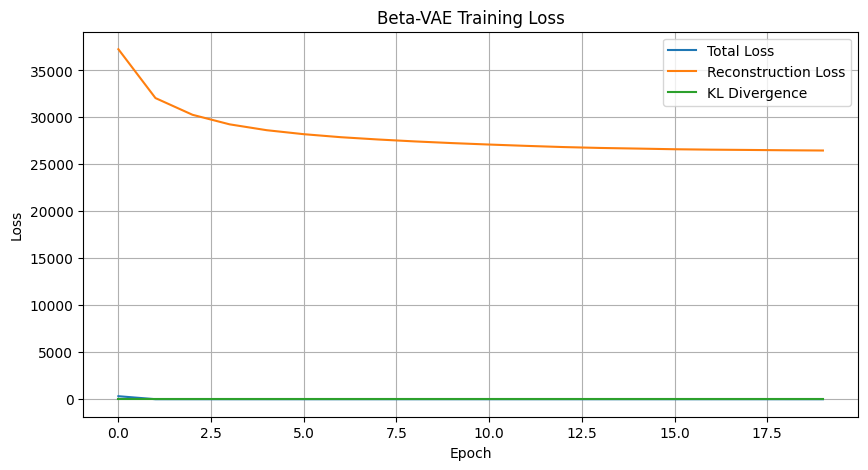

In [24]:
# Plottings losses
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Total Loss')
plt.plot(recons, label='Reconstruction Loss')
plt.plot(kls, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Beta-VAE Training Loss")
plt.grid(True)
plt.show()

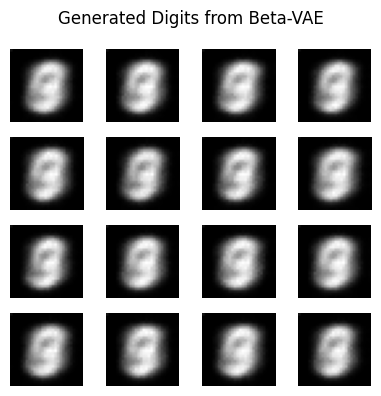

In [25]:
# Generate images
def generate_images(model, num_images=16):
  model.eval()
  with torch.no_grad():
    z = torch.randn(num_images, model.latent_dim).to(device)
    samples = model.decode(z)
  return samples.cpu()


samples = generate_images(model)

# Plot generated digits
plt.figure(figsize=(4, 4))

for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.imshow(samples[i].squeeze(), cmap='gray')
  plt.axis('off')
plt.suptitle('Generated Digits from Beta-VAE')
plt.tight_layout()
plt.show()

In [ ]:
# Tune Beta / increase number of epochs for better generation